# Preproc - ML Latest 30 M from MovieLens

## Etapa 1: Análisis de Datos - Sistema de Recomendación MovieLens
## Curso: CC65 Programación Concurrente y Distribuida
## Dataset: MovieLens 33M (Latest)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from datetime import datetime
import os

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Rutas de los archivos (ajustar según tu estructura)
DATA_PATH = "./dataset/"  # Carpeta con archivos descomprimidos

# Cargar archivos principales
print("\n[1.1] Cargando archivos...")
ratings_df = pd.read_csv(f"{DATA_PATH}ratings.csv")
movies_df = pd.read_csv(f"{DATA_PATH}movies.csv")
tags_df = pd.read_csv(f"{DATA_PATH}tags.csv")
genome_scores_df = pd.read_csv(f"{DATA_PATH}genome-scores.csv")
genome_tags_df = pd.read_csv(f"{DATA_PATH}genome-tags.csv")

print(f"✓ Ratings cargados: {len(ratings_df):,} registros")
print(f"✓ Películas cargadas: {len(movies_df):,} registros")
print(f"✓ Tags cargados: {len(tags_df):,} registros")
print(f"✓ Genome Scores: {len(genome_scores_df):,} registros")
print(f"✓ Genome Tags: {len(genome_tags_df):,} registros")


[1.1] Cargando archivos...
✓ Ratings cargados: 33,832,162 registros
✓ Películas cargadas: 86,537 registros
✓ Tags cargados: 2,328,315 registros
✓ Genome Scores: 18,472,128 registros
✓ Genome Tags: 1,128 registros


## Exploración básica

In [4]:
# Exploración básica
print("\n[1.2] Información de Ratings:")
print(ratings_df.info())
print("\nPrimeras filas:")
print(ratings_df.head())

print("\n[1.3] Estadísticas descriptivas:")
print(ratings_df.describe())


[1.2] Información de Ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 1.0 GB
None

Primeras filas:
   userId  movieId  rating   timestamp
0       1        1     4.0  1225734739
1       1      110     4.0  1225865086
2       1      158     4.0  1225733503
3       1      260     4.5  1225735204
4       1      356     5.0  1225735119

[1.3] Estadísticas descriptivas:
             userId       movieId        rating     timestamp
count  3.383216e+07  3.383216e+07  3.383216e+07  3.383216e+07
mean   1.654380e+05  2.831348e+04  3.542540e+00  1.269362e+09
std    9.534122e+04  4.992865e+04  1.063959e+00  2.541023e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    8.295300e+04  1.219000e+03  3.000000e+00  1.046718e+09

## Conteo de usuarios y películas únicos

In [5]:
# Conteo de usuarios y películas únicos
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
n_ratings = len(ratings_df)

print(f"\n[1.4] Dimensiones del dataset:")
print(f"  - Usuarios únicos: {n_users:,}")
print(f"  - Películas únicas: {n_movies:,}")
print(f"  - Total de ratings: {n_ratings:,}")
print(f"  - Sparsity: {100 * (1 - n_ratings / (n_users * n_movies)):.4f}%")


[1.4] Dimensiones del dataset:
  - Usuarios únicos: 330,975
  - Películas únicas: 83,239
  - Total de ratings: 33,832,162
  - Sparsity: 99.8772%


## PASO 2: LIMPIEZA Y VALIDACIÓN DE DATOS

In [6]:
print("\n" + "="*80)
print("PASO 2: LIMPIEZA Y VALIDACIÓN DE DATOS")
print("="*80)

# 2.1 Verificar duplicados
print("\n[2.1] Verificando duplicados...")
duplicados = ratings_df.duplicated(subset=['userId', 'movieId', 'timestamp']).sum()
print(f"  - Registros duplicados encontrados: {duplicados}")

if duplicados > 0:
    print("  - Eliminando duplicados...")
    ratings_df = ratings_df.drop_duplicates(subset=['userId', 'movieId', 'timestamp'])
    print(f"  ✓ Ratings después de eliminar duplicados: {len(ratings_df):,}")


PASO 2: LIMPIEZA Y VALIDACIÓN DE DATOS

[2.1] Verificando duplicados...
  - Registros duplicados encontrados: 0


In [7]:
# 2.2 Verificar valores nulos
print("\n[2.2] Verificando valores nulos...")
print(ratings_df.isnull().sum())


[2.2] Verificando valores nulos...
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [8]:
# 2.3 Validar rangos de ratings
print("\n[2.3] Validando rangos de ratings...")
invalid_ratings = ratings_df[(ratings_df['rating'] < 0.5) | (ratings_df['rating'] > 5.0)]
print(f"  - Ratings fuera del rango [0.5, 5.0]: {len(invalid_ratings)}")

if len(invalid_ratings) > 0:
    print("  - Eliminando ratings inválidos...")
    ratings_df = ratings_df[(ratings_df['rating'] >= 0.5) & (ratings_df['rating'] <= 5.0)]


[2.3] Validando rangos de ratings...
  - Ratings fuera del rango [0.5, 5.0]: 0


In [9]:
# 2.4 Verificar películas existentes
print("\n[2.4] Verificando consistencia de películas...")
movies_in_ratings = set(ratings_df['movieId'].unique())
movies_in_catalog = set(movies_df['movieId'].unique())
missing_movies = movies_in_ratings - movies_in_catalog
print(f"  - Películas en ratings sin metadata: {len(missing_movies)}")

if len(missing_movies) > 0:
    print(f"  - Eliminando ratings de películas sin metadata...")
    ratings_df = ratings_df[ratings_df['movieId'].isin(movies_in_catalog)]
    print(f"  ✓ Ratings después de limpieza: {len(ratings_df):,}")


[2.4] Verificando consistencia de películas...
  - Películas en ratings sin metadata: 0


In [10]:
# 2.5 Convertir timestamp a datetime
print("\n[2.5] Convirtiendo timestamps...")
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['datetime'].dt.year
ratings_df['month'] = ratings_df['datetime'].dt.month

print(f"  ✓ Rango de fechas: {ratings_df['datetime'].min()} a {ratings_df['datetime'].max()}")


[2.5] Convirtiendo timestamps...
  ✓ Rango de fechas: 1995-01-09 11:46:44 a 2023-07-20 08:53:33


## PASO 3: SELECCIÓN DE CAMPOS RELEVANTES

In [11]:
print("\n" + "="*80)
print("PASO 3: SELECCIÓN DE CAMPOS RELEVANTES")
print("="*80)

# 3.1 Análisis de actividad de usuarios
print("\n[3.1] Analizando actividad de usuarios...")
user_activity = ratings_df.groupby('userId').size()
print(f"  - Media de ratings por usuario: {user_activity.mean():.2f}")
print(f"  - Mediana: {user_activity.median():.2f}")
print(f"  - Usuario más activo: {user_activity.max()} ratings")
print(f"  - Usuario menos activo: {user_activity.min()} ratings")


PASO 3: SELECCIÓN DE CAMPOS RELEVANTES

[3.1] Analizando actividad de usuarios...
  - Media de ratings por usuario: 102.22
  - Mediana: 31.00
  - Usuario más activo: 33332 ratings
  - Usuario menos activo: 1 ratings


In [12]:
# 3.2 Filtrar usuarios con muy pocos ratings (umbral: 20 ratings mínimo)
MIN_USER_RATINGS = 20
print(f"\n[3.2] Filtrando usuarios con menos de {MIN_USER_RATINGS} ratings...")
active_users = user_activity[user_activity >= MIN_USER_RATINGS].index
ratings_filtered = ratings_df[ratings_df['userId'].isin(active_users)]
print(f"  - Usuarios activos: {len(active_users):,}")
print(f"  - Ratings después del filtro: {len(ratings_filtered):,}")


[3.2] Filtrando usuarios con menos de 20 ratings...
  - Usuarios activos: 204,443
  - Ratings después del filtro: 32,490,023


In [13]:
# 3.3 Análisis de popularidad de películas
print("\n[3.3] Analizando popularidad de películas...")
movie_popularity = ratings_filtered.groupby('movieId').size()
print(f"  - Media de ratings por película: {movie_popularity.mean():.2f}")
print(f"  - Mediana: {movie_popularity.median():.2f}")
print(f"  - Película más popular: {movie_popularity.max()} ratings")


[3.3] Analizando popularidad de películas...
  - Media de ratings por película: 391.41
  - Mediana: 5.00
  - Película más popular: 104666 ratings


In [14]:
# 3.4 Filtrar películas con muy pocos ratings (umbral: 50 ratings mínimo)
MIN_MOVIE_RATINGS = 50
print(f"\n[3.4] Filtrando películas con menos de {MIN_MOVIE_RATINGS} ratings...")
popular_movies = movie_popularity[movie_popularity >= MIN_MOVIE_RATINGS].index
ratings_filtered = ratings_filtered[ratings_filtered['movieId'].isin(popular_movies)]
print(f"  - Películas populares: {len(popular_movies):,}")
print(f"  - Ratings después del filtro: {len(ratings_filtered):,}")


[3.4] Filtrando películas con menos de 50 ratings...
  - Películas populares: 16,019
  - Ratings después del filtro: 31,992,759


In [15]:
# 3.5 Dataset final para análisis
print("\n[3.5] Dataset final después de limpieza:")
n_users_final = ratings_filtered['userId'].nunique()
n_movies_final = ratings_filtered['movieId'].nunique()
n_ratings_final = len(ratings_filtered)
sparsity_final = 100 * (1 - n_ratings_final / (n_users_final * n_movies_final))

print(f"  - Usuarios: {n_users_final:,}")
print(f"  - Películas: {n_movies_final:,}")
print(f"  - Ratings: {n_ratings_final:,}")
print(f"  - Sparsity: {sparsity_final:.4f}%")


[3.5] Dataset final después de limpieza:
  - Usuarios: 204,442
  - Películas: 16,019
  - Ratings: 31,992,759
  - Sparsity: 99.0231%


## PASO 4: NORMALIZACIÓN DE RATINGS

In [16]:
print("\n" + "="*80)
print("PASO 4: NORMALIZACIÓN DE RATINGS")
print("="*80)

# 4.1 Crear copia para normalización
ratings_norm = ratings_filtered.copy()

# 4.2 Normalización Min-Max a rango [0, 1]
print("\n[4.1] Aplicando normalización Min-Max [0, 1]...")
min_rating = ratings_norm['rating'].min()
max_rating = ratings_norm['rating'].max()
ratings_norm['rating_normalized'] = (ratings_norm['rating'] - min_rating) / (max_rating - min_rating)

print(f"  - Rating original: rango [{min_rating}, {max_rating}]")
print(f"  - Rating normalizado: rango [{ratings_norm['rating_normalized'].min():.4f}, {ratings_norm['rating_normalized'].max():.4f}]")


PASO 4: NORMALIZACIÓN DE RATINGS

[4.1] Aplicando normalización Min-Max [0, 1]...
  - Rating original: rango [0.5, 5.0]
  - Rating normalizado: rango [0.0000, 1.0000]


In [17]:
# 4.3 Normalización por media de usuario (centrado)
print("\n[4.2] Aplicando normalización centrada por usuario...")
user_means = ratings_norm.groupby('userId')['rating'].transform('mean')
ratings_norm['rating_centered'] = ratings_norm['rating'] - user_means

print(f"  - Rating centrado: rango [{ratings_norm['rating_centered'].min():.4f}, {ratings_norm['rating_centered'].max():.4f}]")
print(f"  - Media de ratings centrados: {ratings_norm['rating_centered'].mean():.6f}")


[4.2] Aplicando normalización centrada por usuario...
  - Rating centrado: rango [-4.4767, 4.2857]
  - Media de ratings centrados: -0.000000


In [18]:
# 4.4 Normalización Z-Score por usuario
print("\n[4.3] Aplicando normalización Z-Score por usuario...")
user_means = ratings_norm.groupby('userId')['rating'].transform('mean')
user_stds = ratings_norm.groupby('userId')['rating'].transform('std')
ratings_norm['rating_zscore'] = (ratings_norm['rating'] - user_means) / (user_stds + 1e-8)

print(f"  - Rating Z-Score: media={ratings_norm['rating_zscore'].mean():.4f}, std={ratings_norm['rating_zscore'].std():.4f}")


[4.3] Aplicando normalización Z-Score por usuario...
  - Rating Z-Score: media=-0.0000, std=0.9965


## PASO 5: GENERACIÓN DE MATRIZ USUARIO-PELÍCULA (SPARSE)

In [19]:
print("\n" + "="*80)
print("PASO 5: GENERACIÓN DE MATRIZ USUARIO-PELÍCULA")
print("="*80)

# 5.1 Crear mapeo de IDs a índices continuos
print("\n[5.1] Creando mapeo de IDs...")
unique_users = ratings_norm['userId'].unique()
unique_movies = ratings_norm['movieId'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(sorted(unique_users))}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(sorted(unique_movies))}

idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}

print(f"  ✓ Usuarios mapeados: {len(user_to_idx):,}")
print(f"  ✓ Películas mapeadas: {len(movie_to_idx):,}")


PASO 5: GENERACIÓN DE MATRIZ USUARIO-PELÍCULA

[5.1] Creando mapeo de IDs...
  ✓ Usuarios mapeados: 204,442
  ✓ Películas mapeadas: 16,019


In [20]:
# 5.2 Crear columnas de índices
ratings_norm['user_idx'] = ratings_norm['userId'].map(user_to_idx)
ratings_norm['movie_idx'] = ratings_norm['movieId'].map(movie_to_idx)

# 5.3 Generar matriz sparse (COO format) con ratings originales
print("\n[5.2] Generando matriz sparse (COO format)...")
row_indices = ratings_norm['user_idx'].values
col_indices = ratings_norm['movie_idx'].values
data = ratings_norm['rating'].values

user_movie_matrix = sparse.csr_matrix(
    (data, (row_indices, col_indices)),
    shape=(len(user_to_idx), len(movie_to_idx))
)

print(f"  ✓ Forma de la matriz: {user_movie_matrix.shape}")
print(f"  ✓ Elementos no-cero: {user_movie_matrix.nnz:,}")
print(f"  ✓ Sparsity: {100 * (1 - user_movie_matrix.nnz / (user_movie_matrix.shape[0] * user_movie_matrix.shape[1])):.4f}%")
print(f"  ✓ Memoria utilizada: {user_movie_matrix.data.nbytes / 1024**2:.2f} MB")


[5.2] Generando matriz sparse (COO format)...
  ✓ Forma de la matriz: (204442, 16019)
  ✓ Elementos no-cero: 31,992,759
  ✓ Sparsity: 99.0231%
  ✓ Memoria utilizada: 244.09 MB


In [21]:
# 5.4 Generar matriz con ratings normalizados
print("\n[5.3] Generando matriz sparse con ratings normalizados...")
data_norm = ratings_norm['rating_normalized'].values
user_movie_matrix_norm = sparse.csr_matrix(
    (data_norm, (row_indices, col_indices)),
    shape=(len(user_to_idx), len(movie_to_idx))
)

print(f"  ✓ Matriz normalizada generada: {user_movie_matrix_norm.shape}")


[5.3] Generando matriz sparse con ratings normalizados...
  ✓ Matriz normalizada generada: (204442, 16019)


In [22]:
# 5.5 Generar matriz con ratings centrados
print("\n[5.4] Generando matriz sparse con ratings centrados...")
data_centered = ratings_norm['rating_centered'].values
user_movie_matrix_centered = sparse.csr_matrix(
    (data_centered, (row_indices, col_indices)),
    shape=(len(user_to_idx), len(movie_to_idx))
)

print(f"  ✓ Matriz centrada generada: {user_movie_matrix_centered.shape}")


[5.4] Generando matriz sparse con ratings centrados...
  ✓ Matriz centrada generada: (204442, 16019)


## PASO 6: ANÁLISIS ESTADÍSTICO Y VISUALIZACIONES


PASO 6: ANÁLISIS ESTADÍSTICO Y VISUALIZACIONES

[6.1] Generando visualizaciones...
  ✓ Gráfico guardado: analisis_distribuciones.png


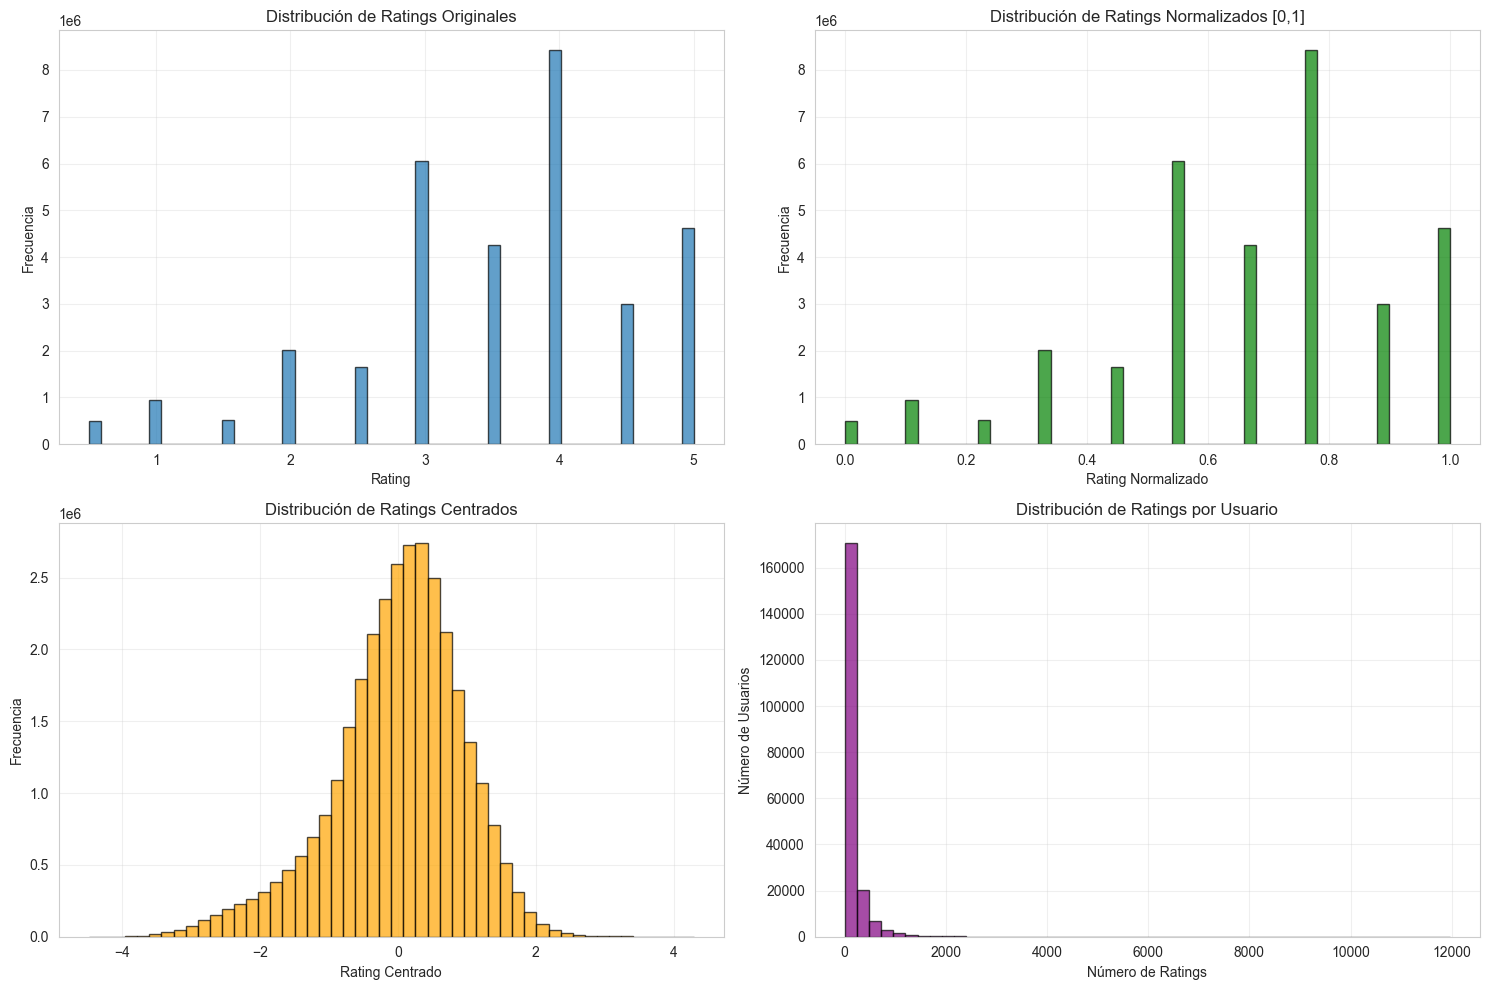

In [23]:
print("\n" + "="*80)
print("PASO 6: ANÁLISIS ESTADÍSTICO Y VISUALIZACIONES")
print("="*80)

# 6.1 Distribución de ratings
print("\n[6.1] Generando visualizaciones...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de ratings originales
axes[0, 0].hist(ratings_norm['rating'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Ratings Originales')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Distribución de ratings normalizados
axes[0, 1].hist(ratings_norm['rating_normalized'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Distribución de Ratings Normalizados [0,1]')
axes[0, 1].set_xlabel('Rating Normalizado')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Distribución de ratings centrados
axes[1, 0].hist(ratings_norm['rating_centered'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Distribución de Ratings Centrados')
axes[1, 0].set_xlabel('Rating Centrado')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].grid(True, alpha=0.3)

# Distribución de ratings por usuario
user_rating_counts = ratings_norm.groupby('userId').size()
axes[1, 1].hist(user_rating_counts, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Distribución de Ratings por Usuario')
axes[1, 1].set_xlabel('Número de Ratings')
axes[1, 1].set_ylabel('Número de Usuarios')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./output/analisis_distribuciones.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: analisis_distribuciones.png")

In [24]:
# 6.2 Top películas más populares
print("\n[6.2] Top 10 películas más populares:")
top_movies = ratings_norm.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
top_movies.columns = ['movieId', 'count', 'avg_rating']
top_movies = top_movies.sort_values('count', ascending=False).head(10)
top_movies = top_movies.merge(movies_df[['movieId', 'title']], on='movieId')
print(top_movies[['title', 'count', 'avg_rating']])


[6.2] Top 10 películas más populares:
                                               title   count  avg_rating
0                   Shawshank Redemption, The (1994)  104666    4.405413
1                                Forrest Gump (1994)  102089    4.052048
2                                Pulp Fiction (1994)  100155    4.196505
3                                 Matrix, The (1999)   95272    4.156489
4                   Silence of the Lambs, The (1991)   92054    4.148603
5          Star Wars: Episode IV - A New Hope (1977)   86569    4.098990
6                                  Fight Club (1999)   78476    4.227891
7                               Jurassic Park (1993)   76820    3.697305
8                            Schindler's List (1993)   75196    4.237546
9  Lord of the Rings: The Fellowship of the Ring,...   74265    4.091025


## PASO 7: EXPORTACIÓN DE DATOS PROCESADOS

In [25]:
print("\n" + "="*80)
print("PASO 7: EXPORTACIÓN DE DATOS PROCESADOS")
print("="*80)

# 7.1 Guardar DataFrame limpio
output_dir = "./output/"
os.makedirs(output_dir, exist_ok=True)

print("\n[7.1] Guardando datos procesados...")
ratings_norm.to_csv(f"{output_dir}ratings_normalized.csv", index=False)
print(f"  ✓ Guardado: {output_dir}ratings_normalized.csv")


PASO 7: EXPORTACIÓN DE DATOS PROCESADOS

[7.1] Guardando datos procesados...
  ✓ Guardado: ./output/ratings_normalized.csv


In [26]:
# 7.2 Guardar mapeos
import json

# Convertir claves a str para evitar TypeError
user_to_idx_str = {str(k): int(v) for k, v in user_to_idx.items()}
movie_to_idx_str = {str(k): int(v) for k, v in movie_to_idx.items()}

with open(f"{output_dir}user_to_idx.json", 'w') as f:
    json.dump(user_to_idx_str, f, indent=2)
print(f"  ✓ Guardado: {output_dir}user_to_idx.json")

with open(f"{output_dir}movie_to_idx.json", 'w') as f:
    json.dump(movie_to_idx_str, f, indent=2)
print(f"  ✓ Guardado: {output_dir}movie_to_idx.json")

  ✓ Guardado: ./output/user_to_idx.json
  ✓ Guardado: ./output/movie_to_idx.json


In [27]:
# 7.3 Guardar matrices sparse
from scipy.sparse import save_npz

save_npz(f"{output_dir}user_movie_matrix.npz", user_movie_matrix)
print(f"  ✓ Guardado: {output_dir}user_movie_matrix.npz")

save_npz(f"{output_dir}user_movie_matrix_normalized.npz", user_movie_matrix_norm)
print(f"  ✓ Guardado: {output_dir}user_movie_matrix_normalized.npz")

save_npz(f"{output_dir}user_movie_matrix_centered.npz", user_movie_matrix_centered)
print(f"  ✓ Guardado: {output_dir}user_movie_matrix_centered.npz")

  ✓ Guardado: ./output/user_movie_matrix.npz
  ✓ Guardado: ./output/user_movie_matrix_normalized.npz
  ✓ Guardado: ./output/user_movie_matrix_centered.npz


In [28]:
# 7.4 Guardar resumen del análisis
summary = {
    "dataset": "MovieLens 33M",
    "fecha_analisis": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "usuarios_originales": int(n_users),
    "peliculas_originales": int(n_movies),
    "ratings_originales": int(n_ratings),
    "usuarios_finales": int(n_users_final),
    "peliculas_finales": int(n_movies_final),
    "ratings_finales": int(n_ratings_final),
    "sparsity_original": float(f"{100 * (1 - n_ratings / (n_users * n_movies)):.4f}"),
    "sparsity_final": float(f"{sparsity_final:.4f}"),
    "min_user_ratings": MIN_USER_RATINGS,
    "min_movie_ratings": MIN_MOVIE_RATINGS,
    "rating_range": [float(min_rating), float(max_rating)]
}

with open(f"{output_dir}analysis_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)
print(f"  ✓ Guardado: {output_dir}analysis_summary.json")

print("\n" + "="*80)
print("✓ ETAPA 1 COMPLETADA CON ÉXITO")
print("="*80)
print("\nArchivos generados:")
print(f"  - ratings_normalized.csv")
print(f"  - user_movie_matrix.npz")
print(f"  - user_movie_matrix_normalized.npz")
print(f"  - user_movie_matrix_centered.npz")
print(f"  - user_to_idx.json")
print(f"  - movie_to_idx.json")
print(f"  - analysis_summary.json")
print(f"  - analisis_distribuciones.png")
print("\nEstos archivos serán utilizados en la Etapa 2 (Filtrado Colaborativo)")

  ✓ Guardado: ./output/analysis_summary.json

✓ ETAPA 1 COMPLETADA CON ÉXITO

Archivos generados:
  - ratings_normalized.csv
  - user_movie_matrix.npz
  - user_movie_matrix_normalized.npz
  - user_movie_matrix_centered.npz
  - user_to_idx.json
  - movie_to_idx.json
  - analysis_summary.json
  - analisis_distribuciones.png

Estos archivos serán utilizados en la Etapa 2 (Filtrado Colaborativo)
